# Bike Demand Prediction Model
### Assignment Solution (IIT Madras – Kaatru)

## Goal
Develop a model to find significant variables in predicting the demand for shared bikes.

## key Improvements in this Version
- **Data Preprocessing**: Handling categorical variables using One-Hot Encoding.
- **Assumption Checking**: Checking Multicollinearity using VIF.
- **Validation**: Using Train-Test Split to evaluate performance on unseen data.
- **Residual Analysis**: Verifying the assumptions of Linear Regression.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## 1. Load and Inspect Data

In [4]:
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## 2. Data Cleaning & Feature Engineering
We drop variables that are not useful for prediction or cause leakage:
- `instant`: Index column.
- `dteday`: Date is redundant as we have year, month, etc.
- `casual`, `registered`: Target leakage (cnt = casual + registered).

In [6]:
df_model = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

### Categorical Encoding
Variables like `season`, `weathersit`, `mnth`, and `weekday` are categorical but encoded as integers. We must One-Hot Encode them to avoid ordinality assumptions (e.g., Season 4 > Season 1 is false logic).

In [7]:
# Define categorical columns
cat_cols = ['season', 'weathersit', 'mnth', 'weekday']

# Create dummy variables (drop_first=True to avoid dummy variable trap)
df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True, dtype=int)
df_model.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_9,mnth_10,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,1,14.110847,18.18125,80.5833,10.749882,985,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,14.902598,17.68695,69.6087,16.652113,801,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,...,0,0,0,0,0,0,0,0,1,0


## 3. Multicollinearity Check (VIF)
High correlation between independent variables affects the p-values and interpretation. We check Variance Inflation Factor (VIF).

In [8]:
numeric_cols = ['temp', 'atemp', 'hum', 'windspeed']
X_numeric = df[numeric_cols]
X_numeric = sm.add_constant(X_numeric)

vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(len(X_numeric.columns))]
vif_data

,feature,VIF
0,const,45.583073
1,temp,62.921157
2,atemp,63.584456
3,hum,1.079536
4,windspeed,1.126745


**Observation**: `temp` and `atemp` have extremely high VIF (~63), indicating they are duplicates in information. We will drop `atemp`.

In [9]:
df_model = df_model.drop(['atemp'], axis=1)

## 4. Train-Test Split
Splitting data into 70% Training and 30% Testing.

In [10]:
X = df_model.drop('cnt', axis=1)
y = df_model['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Train size: (511, 28)
Test size: (219, 28)


## 5. Model Building (OLS Regression)

In [11]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

lr_model = sm.OLS(y_train, X_train_sm).fit()
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     97.86
Date:                Sun, 14 Dec 2025   Prob (F-statistic):          3.74e-179
Time:                        17:47:51   Log-Likelihood:                -4111.2
No. Observations:                 511   AIC:                             8280.
Df Residuals:                     482   BIC:                             8403.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1949.0741    277.971      7.012   

## 6. Residual Analysis
Validating assumptions:
1. **Normality of Residuals**: Distribution of error terms should be normal.
2. **Homoscedasticity**: No pattern in residuals vs fitted values.

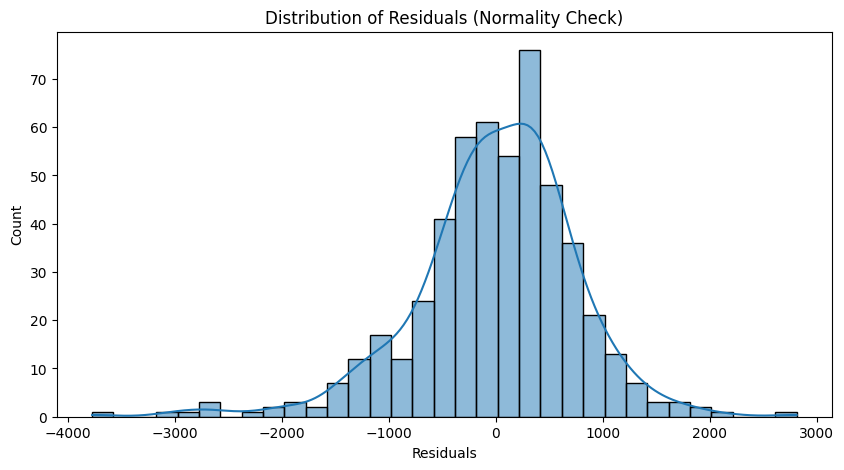

In [12]:
y_train_pred = lr_model.predict(X_train_sm)
residuals = y_train - y_train_pred

plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals (Normality Check)')
plt.xlabel('Residuals')
plt.show()

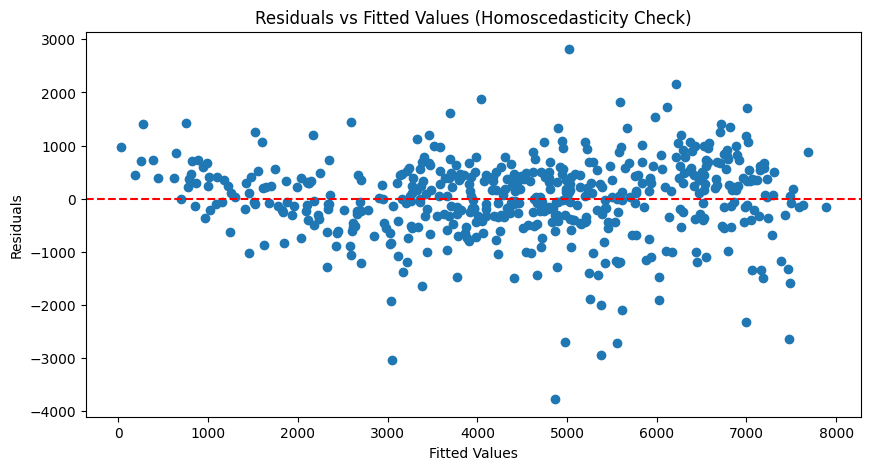

In [13]:
plt.figure(figsize=(10,5))
plt.scatter(y_train_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values (Homoscedasticity Check)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

## 7. Model Evaluation
checking performance on Test Data.

In [14]:
y_test_pred = lr_model.predict(X_test_sm)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train R-squared: {r2_train:.4f}")
print(f"Test R-squared: {r2_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

Train R-squared: 0.8504
Test R-squared: 0.8284
Test RMSE: 784.7049


## 8. Final Outcome: Significant Variables
Listing variables that are statistically significant ($p < 0.05$).

In [15]:
p_values = lr_model.pvalues
sig_vars = p_values[p_values < 0.05].index.tolist()

print("Significant Variables (p < 0.05):")
for var in sig_vars:
    print(f"- {var}")

Significant Variables (p < 0.05):
- const
- yr
- holiday
- temp
- hum
- windspeed
- season_2
- season_4
- weathersit_2
- weathersit_3
- mnth_3
- mnth_5
- mnth_8
- mnth_9
- mnth_10
